# Import Libraries

In [88]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from sklearn.preprocessing import scale
from corpora_utils import CorporaHelper,CorporaDomains, CorporaProperties
import numpy as np
import os
import pickle
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Bidirectional
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

In [54]:
print(tf.__version__)

2.1.0


# GPU Config

In [55]:
config = tf.compat.v1.ConfigProto(
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
    # device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [ ]:
# example corpus

#corpus = 'All this not sleeping has a terrible way of playing with your memory.' # fear => test
#corpus = "The Rock is destined to be the 21st Century s new Conan and that he s going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."
corpus = 'If you sometimes like to go to the movies to have fun , Wasabi is a good place to start .' # joy 

In [82]:
# load data
labels = []
texts = []
corpora_helper = CorporaHelper("multigenre.csv")
count_joy = 0
count_sadness = 0
count_anger = 0
count_fear = 0
number_of_classes: 4
max_per_emotion = 240
max_data = 4*240

In [57]:
for index, corpus in corpora_helper.get_data().iterrows():
    # only moviereviews
    if True or corpus[CorporaProperties.DOMAIN.value] == CorporaDomains.MOVIEREVIEW.value:
        # only joy
        # only disgust
        if corpus[CorporaProperties.EMOTION.value] == 'anger':
            if max_per_emotion > count_anger:
                texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
                labels.append(0)
                count_anger += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'fear':
            if max_per_emotion > count_fear:
                texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
                labels.append(1)
                count_fear += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'joy':
            if max_per_emotion > count_joy:
                texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
                labels.append(2)
                count_joy += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'sadness':
            if max_per_emotion > count_sadness:
                texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
                labels.append(3)
                count_sadness += 1
print('number of anger labels: ',count_anger)
print('number of fear labels: ', count_fear)
print('number of joy labels: ',count_joy)
print('number of sadness labels: ', count_sadness)

number of anger labels:  240
number of fear labels:  240
number of joy labels:  240
number of sadness labels:  240


In [58]:
# 0 anger
# 1 fear
# 2 joy
# 3 sadness

In [59]:
## Create one hot encoding
maxlen = 100 # max. number of words in sequences
training_samples = int(max_data * 0.7) #672  70% of 960
validation_samples = int(max_data * 0.2) # 192 20% of 960
test_samples = int(max_data * 0.1) #96  10% of 960
max_words = 10000

In [60]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [61]:
#one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
#print(one_hot_results)

word_index = tokenizer.word_index
print ('%s eindeutige Tokens gefunden.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data:', data.shape)
print('Shape of labels:', labels.shape)

4134 eindeutige Tokens gefunden.
Shape of data: (960, 100)
Shape of labels: (960,)


In [62]:
# mix the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [63]:
# split in train and validate
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[training_samples + validation_samples: training_samples + validation_samples + test_samples]
y_test = labels[training_samples + validation_samples: training_samples + validation_samples + test_samples]

In [64]:
# Load prepared Multigenre embedding

word_embeddings_path = 'multigenre_final_embeddings.pkl'
with open(word_embeddings_path, 'rb') as word_embeddings_file:
    embedding_info = pickle.load(word_embeddings_file)

In [65]:
word_indicies_path = 'word_indices.pickle'
with open(word_indicies_path, 'rb') as word_indicies_file:
    word_indices = pickle.load(word_indicies_file)

In [66]:
#helper functions
def is_active_vector_method(string):
    return int(string)
    
def get_unigram_embedding(word, word_embedding_dict, bin_string):
    
    if word in word_embedding_dict:
        word_feature_embedding_dict = word_embedding_dict[word]
        final_embedding = np.array([])
    else:
        return None
    
    for i in range(16):
        if is_active_vector_method(bin_string[i]):
            final_embedding = np.append(final_embedding, word_feature_embedding_dict[i])
    
    return final_embedding

In [67]:
# 
unigram_feature_string = "1111111111111111"
word_indices_len = len(word_indices)
pre_padding = 0
embeddings_index = embedding_info[0]
MAX_SEQUENCE_LENGTH = embedding_info[1]
maxlen = MAX_SEQUENCE_LENGTH
#MAX_NB_WORDS = 10000

In [68]:
EMBEDDING_DIM = len(get_unigram_embedding("glad", embedding_info[0], unigram_feature_string))
print("Embedding dimension:",EMBEDDING_DIM)

Embedding dimension: 2071


In [69]:
# Matrix
word_embedding_matrix = list()
word_embedding_matrix = np.zeros((max_words, EMBEDDING_DIM)) # evtl. change to word_indices_len
#word_embedding_matrix.append(np.zeros(EMBEDDING_DIM))

In [70]:
for word, i in word_index.items(): # sorted(word_indices, key=word_indices.get):
    embedding_features = get_unigram_embedding(word, embedding_info[0], unigram_feature_string)
    if i < max_words:
        if embedding_features is not None:
            # Words not found in embedding index will be all-zeros.
            word_embedding_matrix[i] = embedding_features

word_embedding_matrix = np.asarray(word_embedding_matrix, dtype='f')
word_embedding_matrix = scale(word_embedding_matrix)

C:\Users\COMMANDER\.conda\envs\gputest\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\COMMANDER\.conda\envs\gputest\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [71]:
print('word_indices_len',word_indices_len)
print('EMBEDDING_DIM',EMBEDDING_DIM)
print('input_length', MAX_SEQUENCE_LENGTH + pre_padding)
embedding = Embedding(max_words, EMBEDDING_DIM, input_length=maxlen, trainable=False)
#embedding = Embedding(word_indices_len + 1, EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH + pre_padding, trainable=False)

word_indices_len 22122
EMBEDDING_DIM 2071
input_length 49


In [72]:
# Prepare data
#maxlen = 100 # max. number of words in sequences

training_samples = int(max_data * 0.7) #672  70% of 960
validation_samples = int(max_data * 0.2) # 192 20% of 960
test_samples = int(max_data * 0.1) #96  10% of 960

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data:', data.shape)
print('Shape of labels:', labels.shape)

Shape of data: (960, 49)
Shape of labels: (960,)


In [73]:
# mix the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [74]:
# split in train and validate
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[training_samples + validation_samples: training_samples + validation_samples + test_samples]
y_test = labels[training_samples + validation_samples: training_samples + validation_samples + test_samples]

In [77]:
# Create model
model = Sequential()
model.add(embedding)
model.add(Flatten()) #3D to 2D
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 49, 2071)          20710000  
_________________________________________________________________
flatten_3 (Flatten)          (None, 101479)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                3247360   
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 132       
Total params: 23,957,492
Trainable params: 3,247,492
Non-trainable params: 20,710,000
_________________________________________________________________


In [93]:
model = Sequential()
model.add(embedding)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 49, 2071)          20710000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                538624    
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 260       
Total params: 21,248,884
Trainable params: 538,884
Non-trainable params: 20,710,000
_________________________________________________________________


In [90]:
# Load GloVe embedding
model.layers[0].set_weights([word_embedding_matrix])
model.layers[0].trainable = False

In [94]:
# Train and Evaluate
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 672 samples, validate on 192 samples
Epoch 1/10
672/672 [==============================] - 2s 3ms/step - loss: 1.4468 - acc: 0.2336 - val_loss: 1.4442 - val_acc: 0.1979
Epoch 2/10
672/672 [==============================] - 1s 2ms/step - loss: 1.0334 - acc: 0.7292 - val_loss: 1.4824 - val_acc: 0.1875
Epoch 3/10
672/672 [==============================] - 1s 2ms/step - loss: 0.7777 - acc: 0.8557 - val_loss: 1.5518 - val_acc: 0.1562
Epoch 4/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5628 - acc: 0.9286 - val_loss: 1.6000 - val_acc: 0.1771
Epoch 5/10
672/672 [==============================] - 1s 2ms/step - loss: 0.4116 - acc: 0.9643 - val_loss: 1.6666 - val_acc: 0.1875
Epoch 6/10
672/672 [==============================] - 1s 2ms/step - loss: 0.3082 - acc: 0.9777 - val_loss: 1.7367 - val_acc: 0.1927
Epoch 7/10
672/672 [==============================] - 1s 2ms/step - loss: 0.2345 - acc: 0.9881 - val_loss: 1.7760 - val_acc: 0.2135
Epoch 8/10
672/672 [==========

In [97]:
# Test model
print("Evaluate on test data")
model.load_weights('pre_trained_glove_model.h5')
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

model.save('emotion_deep1.h5')

Evaluate on test data


ValueError: Layer #1 (named "bidirectional_2" in the current model) was found to correspond to layer dense_1 in the save file. However the new layer bidirectional_2 expects 6 weights, but the saved weights have 2 elements.

In [81]:
## Example use of the model!
test_corpora = ['I hate you bastard ! Go away !', 'This is a lovely film , but it makes me sad .','That is because - damn it !']
test_corpora.append('Die bitch ! You make me angry .')
test_corpora.append('My son died .')
test_corpora.append('I am afraid because of this horror .')
for text in test_corpora:
    textarray = [text]
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(textarray)
    sequences = tokenizer.texts_to_sequences(textarray)
    data = pad_sequences(sequences, maxlen=maxlen)
    print(text)
    pred = model.predict(data)
    print("prediction:", pred)

I hate you bastard ! Go away !
prediction: [[0.24499951 0.2548284  0.251248   0.24892409]]
This is a lovely film , but it makes me sad .
prediction: [[0.24499951 0.2548284  0.251248   0.24892409]]
That is because - damn it !
prediction: [[0.2529243  0.02797827 0.5946836  0.12441383]]
Die bitch ! You make me angry .
prediction: [[0.24499951 0.2548284  0.251248   0.24892409]]
My son died .
prediction: [[0.24499951 0.2548284  0.251248   0.24892409]]
I am afraid because of this horror .
prediction: [[4.7252487e-02 1.5927006e-05 9.4916809e-01 3.5635375e-03]]


In [95]:
#BIDIRECTIONAL LSTM
test_corpora = ['I hate you bastard ! Go away !', 'This is a lovely film , but it makes me sad .','That is because - damn it !']
test_corpora.append('Die bitch ! You make me angry .')
test_corpora.append('My son died .')
test_corpora.append('I am afraid because of this horror .')
for text in test_corpora:
    textarray = [text]
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(textarray)
    sequences = tokenizer.texts_to_sequences(textarray)
    data = pad_sequences(sequences, maxlen=maxlen)
    print(text)
    pred = model.predict(data)
    print("prediction:", pred)

I hate you bastard ! Go away !
prediction: [[0.64497405 0.06755104 0.15933037 0.12814452]]
This is a lovely film , but it makes me sad .
prediction: [[0.30835295 0.2639359  0.36092043 0.0667908 ]]
That is because - damn it !
prediction: [[0.47354943 0.0613214  0.40170935 0.06341977]]
Die bitch ! You make me angry .
prediction: [[0.64497405 0.06755104 0.15933037 0.12814452]]
My son died .
prediction: [[0.35378578 0.05312883 0.51484823 0.07823712]]
I am afraid because of this horror .
prediction: [[0.3499249  0.03514227 0.5521307  0.06280213]]


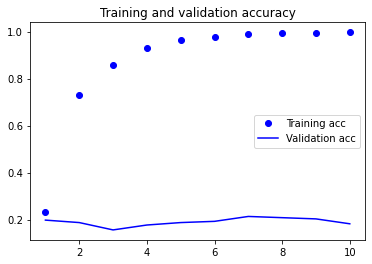

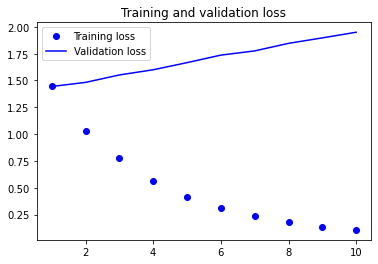

In [96]:
# Plot performance
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
